In [4]:
pip install pyforest # to import all libraries.

     |████████████████████████████████| 3.4MB 2.2MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/77/f9/78/51500678d6ce472b574216a40cba6c81d1766ee7cc838cce3c
Successfully built pyforest
Note: you may need to restart the kernel to use updated packages.


In [5]:
from pyforest import*
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')



Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          90 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.20.0-py_0 conda-forge


geopy-1.20.0         | 57 KB     | ##################################### | 100% 
geographiclib-1.49   | 

In [6]:
pip install BeautifulSoup4

     |████████████████████████████████| 102kB 2.8MB/s ta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [7]:
from bs4 import BeautifulSoup

#### To get the geocodes with define function i.e latitude and longitude of a given location using geopy.

In [8]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

#### I define a function to interact with FourSquare API and get top 20 venues within a radius of 1000 Metres for a given latitude and longitude. 
#### The function below will return with venue id , venue name and category.

In [9]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=20
    CLIENT_ID ='ND1RRO1PE4PKV5PR24KGRU0OXIRLZIFTMCVHUJL1DC3ZUIPO' # your Foursquare ID
    CLIENT_SECRET ='L2HTSUD1FV3I1TVJOGHDJRXKOKODHOMZHKP42KTVPPWQ54D2' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### In this step i will define a function to get venue details like rating ,likes,names, tip counts for a given venue id. which will be used for ranking.

In [10]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'ND1RRO1PE4PKV5PR24KGRU0OXIRLZIFTMCVHUJL1DC3ZUIPO'# your Foursquare ID
    CLIENT_SECRET = 'L2HTSUD1FV3I1TVJOGHDJRXKOKODHOMZHKP42KTVPPWQ54D2' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### Here i will take a help of define a function to get the New York city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [11]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [12]:
# get new york data
import requests # library to handle requests
new_york_data=get_new_york_data()

In [13]:
new_york_data.shape

(306, 4)

#### It shows that there is 306 different Neighborhoods in New York

In [14]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [15]:
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

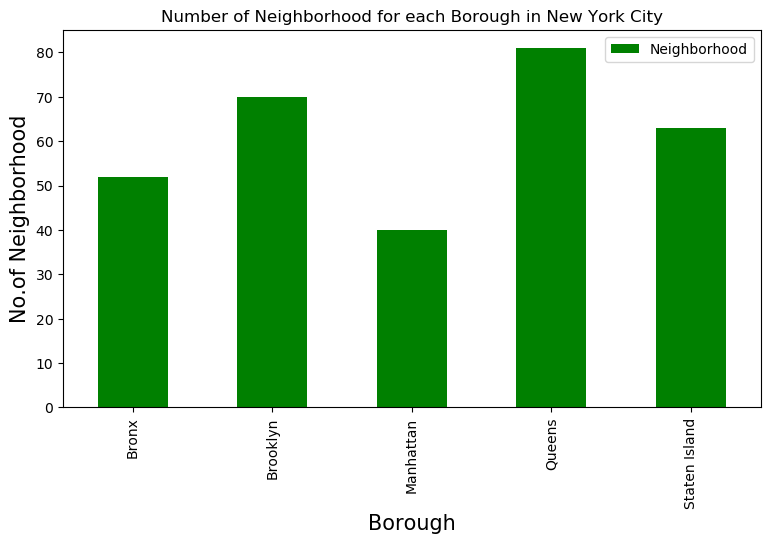

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar',color='green')
#legend
plt.legend()
#displays the plot
plt.show()

In [3]:
#### The figure above shows that Queens has highest number of neighborhoods

In [26]:
# prepare neighborhood list that contains Korean resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
korean_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    korean_resturants=venues[venues['Category']=='Korean Restaurant']   
    print('(',count,'/',len(new_york_data),')','Korean Resturants in '+Neighborhood+', '+Borough+':'+str(len(korean_resturants)))
    for resturant_detail in korean_resturants.values.tolist():
        id, name , category=resturant_detail
        korean_rest_ny = korean_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1


( 1 / 306 ) Korean Resturants in Wakefield, Bronx:0
( 2 / 306 ) Korean Resturants in Co-op City, Bronx:0
( 3 / 306 ) Korean Resturants in Eastchester, Bronx:0
( 4 / 306 ) Korean Resturants in Fieldston, Bronx:0
( 5 / 306 ) Korean Resturants in Riverdale, Bronx:0
( 6 / 306 ) Korean Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Korean Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Korean Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Korean Resturants in Norwood, Bronx:0
( 10 / 306 ) Korean Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Korean Resturants in Baychester, Bronx:0
( 12 / 306 ) Korean Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Korean Resturants in City Island, Bronx:0
( 14 / 306 ) Korean Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Korean Resturants in University Heights, Bronx:0
( 16 / 306 ) Korean Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Korean Resturants in Fordham, Bronx:0
( 18 / 306 ) Korean Resturants in East Tremont, Bronx:0
( 19 / 306 ) Kor

#### this data have got all the Korean restaurants in New York city for analyzation.

In [27]:
korean_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Brighton Beach,4c9d5c0303133704a96f5ed5,Cafe At Your Mother-in-Law
1,Brooklyn,Prospect Heights,4fa162e0e4b0badc81404a51,Kimchi Grill
2,Brooklyn,Williamsburg,52bf3053498e754b09a440b5,Dotory
3,Manhattan,East Village,578bec6c498e3150fc369f3b,Thursday Kitchen
4,Manhattan,Manhattan Valley,56a14149498e9983c0199038,Mokja


In [28]:
korean_rest_ny.shape

(26, 4)

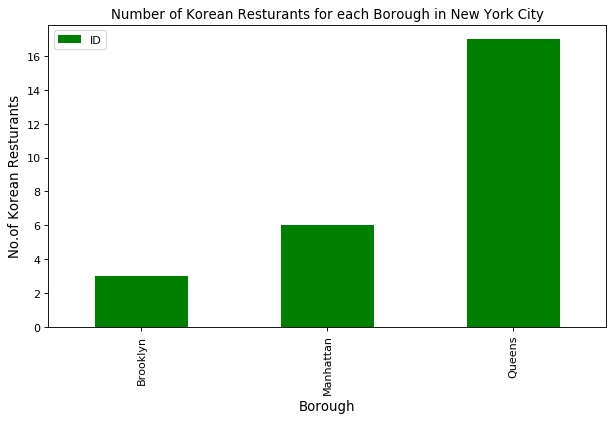

In [29]:
plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Korean Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 12)
#On y-axis
plt.ylabel('No.of Korean Resturants', fontsize=12)
#giving a bar plot
korean_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar',color=['green'])
#legend
plt.legend()
#displays the plot
plt.show()


#### the above figure shows that Queens has the largest number of Korean restaurants

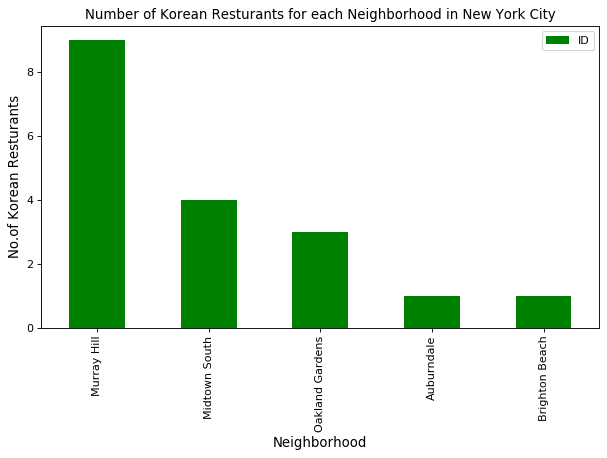

In [30]:
plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Korean Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 12)
#On y-axis
plt.ylabel('No.of Korean Resturants', fontsize=12)
#giving a bar plot
korean_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar',color=['green'])
#legend
plt.legend()
#displays the plot
plt.show()


In [31]:
korean_rest_ny[korean_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
11,Queens,Murray Hill,4b830e44f964a520ebf430e3,Hahm Ji Bach - 함지박
12,Queens,Murray Hill,4b8f0931f964a520d04533e3,Mapo BBQ
13,Queens,Murray Hill,49e10e0bf964a52089611fe3,Mad For Chicken
14,Queens,Murray Hill,4baeabe6f964a52037cd3be3,Kum Sung Chik Naengmyun
15,Queens,Murray Hill,4c7ad3dda86837048bee144d,Geo Si Gi Restaurant
16,Queens,Murray Hill,5518a1a8498e4c7fe6268b88,Jongro BBQ
17,Queens,Murray Hill,5590598a498eb1c3f975b6a6,Mr. Tofu
18,Queens,Murray Hill,56db53cc498eed9b68621019,SGD Tofu House
19,Queens,Murray Hill,4ad3bfabf964a52016e620e3,Han Joo


#### So Murray Hills in Queens has the largest number of Korean Resturants with a total count of 9.

In [32]:
# prepare neighborhood list that contains korean resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
korean_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in korean_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        
# we will assign 0 value for these resturants as they may have been 
#recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*1
    print('(',count,'/',len(korean_rest_ny),')','processed')
    korean_rest_stats_ny = korean_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                        Name  Likes  Rating  Tips
0  4c9d5c0303133704a96f5ed5  Cafe At Your Mother-in-Law     29     7.5    28
( 1 / 26 ) processed
                         ID          Name  Likes  Rating  Tips
0  4fa162e0e4b0badc81404a51  Kimchi Grill    289     8.4   108
( 2 / 26 ) processed
                         ID    Name  Likes  Rating  Tips
0  52bf3053498e754b09a440b5  Dotory    138     8.5    44
( 3 / 26 ) processed
                         ID              Name  Likes  Rating  Tips
0  578bec6c498e3150fc369f3b  Thursday Kitchen    274     8.9    72
( 4 / 26 ) processed
                         ID   Name  Likes  Rating  Tips
0  56a14149498e9983c0199038  Mokja     23     7.9     6
( 5 / 26 ) processed
                         ID      Name  Likes  Rating  Tips
0  4ae39cb6f964a520439721e3  Debasaki     67     8.4    35
( 6 / 26 ) processed
                         ID                     Name  Likes  Rating  Tips
0  4d3c9f7ea2e4b1f707f4ea25  Sky Garden @ 

In [33]:
korean_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Brighton Beach,4c9d5c0303133704a96f5ed5,Cafe At Your Mother-in-Law,29,7.5,28
1,Brooklyn,Prospect Heights,4fa162e0e4b0badc81404a51,Kimchi Grill,289,8.4,108
2,Brooklyn,Williamsburg,52bf3053498e754b09a440b5,Dotory,138,8.5,44
3,Manhattan,East Village,578bec6c498e3150fc369f3b,Thursday Kitchen,274,8.9,72
4,Manhattan,Manhattan Valley,56a14149498e9983c0199038,Mokja,23,7.9,6


#### So we got data for all restaurants now i will save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required



In [37]:
korean_rest_stats_ny.to_csv('korean_rest_stats_ny.csv', index=False)

In [38]:
korean_rest_stats_ny_csv=pd.read_csv('korean_rest_stats_ny.csv')

In [39]:
korean_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Brighton Beach,4c9d5c0303133704a96f5ed5,Cafe At Your Mother-in-Law,29,7.5,28
1,Brooklyn,Prospect Heights,4fa162e0e4b0badc81404a51,Kimchi Grill,289,8.4,108
2,Brooklyn,Williamsburg,52bf3053498e754b09a440b5,Dotory,138,8.5,44
3,Manhattan,East Village,578bec6c498e3150fc369f3b,Thursday Kitchen,274,8.9,72
4,Manhattan,Manhattan Valley,56a14149498e9983c0199038,Mokja,23,7.9,6


In [40]:

korean_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 7 columns):
Borough         26 non-null object
Neighborhood    26 non-null object
ID              26 non-null object
Name            26 non-null object
Likes           26 non-null object
Rating          26 non-null float64
Tips            26 non-null object
dtypes: float64(1), object(6)
memory usage: 1.5+ KB


#### We see that values like Tips and likes are strig values. We  need to convert them into float for further analysis

In [43]:
korean_rest_stats_ny['Likes']=korean_rest_stats_ny['Likes'].astype('float64')
korean_rest_stats_ny['Tips']=korean_rest_stats_ny['Tips'].astype('float64')

In [41]:
korean_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 7 columns):
Borough         26 non-null object
Neighborhood    26 non-null object
ID              26 non-null object
Name            26 non-null object
Likes           26 non-null object
Rating          26 non-null float64
Tips            26 non-null object
dtypes: float64(1), object(6)
memory usage: 1.5+ KB


In [44]:
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Likes'].idxmax()]
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Rating'].idxmax()]
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood               Midtown South
ID              517563f9498e0a4859d08fe4
Name                      BCD Tofu House
Likes                               1198
Rating                                 9
Tips                                 199
Name: 23, dtype: object

#### Now we need to visualize neighborhood with maximum average rating of restaurants

In [46]:
ny_neighborhood_stats=korean_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']


In [47]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
7,Midtown South,9.025000
3,East Village,8.900000
0,Auburndale,8.600000
12,Williamsburg,8.500000
4,Flushing,8.400000
10,Prospect Heights,8.400000
11,Sunnyside Gardens,8.300000
8,Murray Hill,8.111111
6,Manhattan Valley,7.900000
2,College Point,7.800000


#### Same as these are the average rating of Korean Restaurants for each Borough

In [48]:
ny_borough_stats=korean_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']


In [49]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.816667
0,Brooklyn,8.133333
2,Queens,8.023529


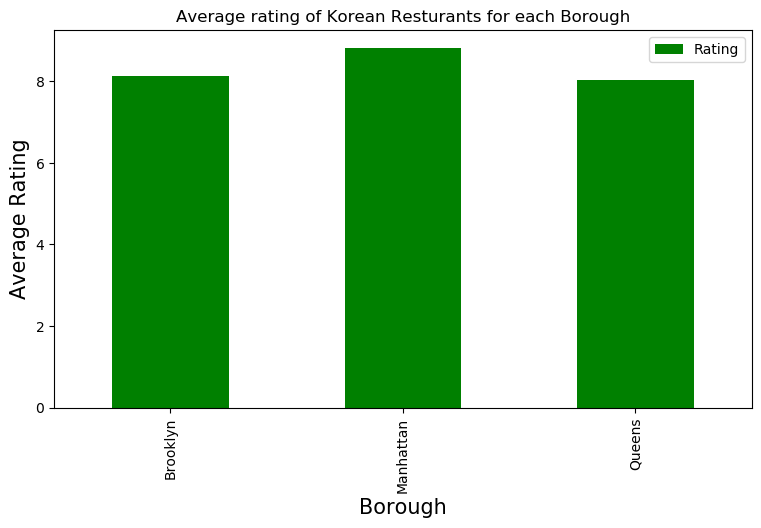

In [50]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Korean Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
korean_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar',color=['green'])
#legend
plt.legend()
#displays the plot
plt.show()


#### here i  will consider all the neighborhoods with average rating greater or equal 8.8 to visualize on map

In [51]:

ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.8]

In [52]:
ny_neighborhood_stats

,Neighborhood,Average Rating
3,East Village,8.900
7,Midtown South,9.025


#### here it is needed to join this dataset to original New York data to get longitude and latitude.

In [56]:

ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [57]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [58]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,East Village,40.727847,-73.982226,8.900
1,Manhattan,Midtown South,40.748510,-73.988713,9.025


#### Now I will show this data on a map.

In [59]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)


In [60]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


####  now Lets add a new field to data frame for labeling purpose.

In [61]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'


In [62]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)  
    
# add incidents to map
ny_map.add_child(incidents)

#### Now i have visualized the Neighborhoods. Next i will visualize boroughs based on average rating


In [63]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display 

# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')